In [2]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn import train_nn as tnn

## GNN

In [2]:
gnn_df = pd.read_csv('./data/wandb_gnn/wandb_export_2023-11-01T04_26_32.987-07_00.csv', index_col=0)

In [77]:
sweep_df = pd.read_csv('./data/wandb_gnn/wandb_export_2023-11-06T16_04_54.870-08_00.csv', index_col=0)

In [79]:
sweep_df['dG_37_pred'] = util.get_dG(dH=sweep_df.dH_pred, Tm=sweep_df.Tm_pred, celsius=37)

AttributeError: 'DataFrame' object has no attribute 'dH_pred'

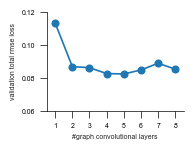

In [43]:
fig, ax = plt.subplots()
ax.plot(np.arange(1,9), sweep_df['test_rmse'], 'o-')
ax.set_ylim([.06,.12])
ax.set_xlim([0.5,8.5])
ax.set_xlabel('#graph convolutional layers')
ax.set_ylabel('validation total rmse loss')
util.beutify(ax, x_locator=1, y_locator=.02, shrink=True)
util.save_fig('./fig/Fig5/n_graphconv_vs_test_rmse.pdf')

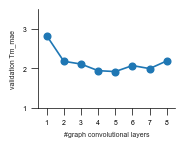

In [40]:
y = 'Tm_mae'
fig, ax = plt.subplots()
ax.plot(np.arange(1,9), sweep_df[y], 'o-')
ax.set_ylim([1,3.5])
ax.set_xlim([0.5,8.5])
ax.set_xlabel('#graph convolutional layers')
ax.set_ylabel('validation %s'%y)
util.beutify(ax, x_locator=1, y_locator=1, shrink=True)
util.save_fig('./fig/Fig5/n_graphconv_vs_%s.pdf'%y)

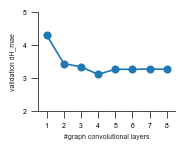

In [41]:
y = 'dH_mae'
fig, ax = plt.subplots()
ax.plot(np.arange(1,9), sweep_df[y], 'o-')
ax.set_ylim([2,5])
ax.set_xlim([0.5,8.5])
ax.set_xlabel('#graph convolutional layers')
ax.set_ylabel('validation %s'%y)
util.beutify(ax, x_locator=1, y_locator=1, shrink=True)
util.save_fig('./fig/Fig5/n_graphconv_vs_%s.pdf'%y)

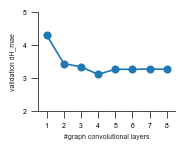

In [41]:
y = 'dH_mae'
fig, ax = plt.subplots()
ax.plot(np.arange(1,9), sweep_df[y], 'o-')
ax.set_ylim([2,5])
ax.set_xlim([0.5,8.5])
ax.set_xlabel('#graph convolutional layers')
ax.set_ylabel('validation %s'%y)
util.beutify(ax, x_locator=1, y_locator=1, shrink=True)
util.save_fig('./fig/Fig5/n_graphconv_vs_%s.pdf'%y)

## Test

In [15]:
dir_name = './data/wandb_gnn/test_200epoch/'
fn_list = os.listdir(dir_name)
report_dict = {fn.replace('.csv','') : pd.read_csv(os.path.join(dir_name, fn), index_col=0)
                   for fn in fn_list if fn.endswith('.csv')}

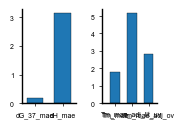

In [16]:
run_name = 'ancient-sound-259'
fig, ax = plt.subplots(1, 2, figsize=(5*cm,3.5*cm))
kwargs = dict(edgecolor='k', linewidth=.25, width=.6)

values = report_dict['summary'].loc[run_name, ['dG_37_mae', 'dH_mae']]
ax[0].bar(values.index, values, **kwargs)
ax[0].set_xlim([-.5, 1.5])

values = report_dict['summary'].loc[run_name, ['Tm_mae', 'Tm_mae_adj_lit_uv', 'Tm_mae_adj_ov']]
ax[1].bar(values.index, values, **kwargs)
ax[1].set_xlim([-.8, 2.5])

for a in ax:
    a.set_ylim(bottom=0)
    util.beutify(a, shrink=True, do_not_resize=True)
    
plt.tight_layout()
util.save_fig(f'./fig/Fig5/test_{run_name}_mae.pdf')

In [17]:
report_dict['summary'].loc[run_name, ['dG_37_mae', 'dH_mae']]

dG_37_mae    0.183115
dH_mae       3.130506
Name: ancient-sound-259, dtype: object

In [20]:
def clean_df(df):
    df = df[[c for c in df.columns if not '__M' in c]]
    df['epoch'] = df.reset_index().Step.apply(lambda x: x+10).values
    df = pd.melt(df, id_vars=['epoch'])
    return df

# report_dict['Tm_corr_lit_uv'] = clean_df(report_dict['Tm_corr_lit_uv'])

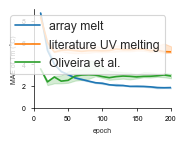

In [21]:
fig, ax = plt.subplots()
kwargs = dict(x='epoch', y='value', estimator='median', errorbar=('pi', 95), ax=ax)
sns.lineplot(clean_df(report_dict['Tm_mae_adj_arr']), label='array melt', **kwargs)
sns.lineplot(clean_df(report_dict['Tm_mae_adj_lit_uv']), label='literature UV melting', **kwargs)
sns.lineplot(clean_df(report_dict['Tm_mae_adj_ov']), label='Oliveira et al.', **kwargs)

ax.set_xlim([0,200])
ax.set_ylim(bottom=0)
ax.set_xlabel('epoch')
ax.set_ylabel('MAE of Tm (°C)')
util.beutify(ax, shrink=True)
plt.legend()

util.save_fig('./fig/Fig5/test_200epoch_mae_history.pdf')

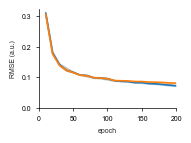

In [22]:
fig, ax = plt.subplots()
kwargs = dict(x='epoch', y='value', estimator='median', errorbar=('pi', 95), ax=ax)
sns.lineplot(clean_df(report_dict['train_rmse']), label='train RMSE', **kwargs)
sns.lineplot(clean_df(report_dict['test_rmse']), label='test RMSE', **kwargs)
ax.set_xlim([0,200])
ax.set_ylim(bottom=0)
ax.set_xlabel('epoch')
ax.set_ylabel('RMSE (a.u.)')
ax.get_legend().remove()
util.beutify(ax, shrink=True, y_locator=.1)

util.save_fig('./fig/Fig5/test_200epoch_train_test_rmse_history.pdf')

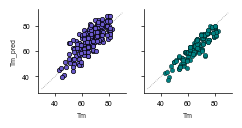

In [23]:
lit_uv_val_result_df = report_dict['soft-yoghurt_lit_uv_table'].reset_index()
val_df = pd.read_csv('./data/models/raw/combined_dataset.csv', index_col=0)
data_split = fileio.read_json('./data/models/raw/combined_data_split.json')

# Get lit_uv_df
split = 'test'
dataset_name = 'lit_uv'
dataset_mask =val_df.eval('dataset == "%s"' % dataset_name)
split_ind = np.searchsorted(val_df.index, 
        data_split[split+'_ind'])
ind = list(set(split_ind) & set(np.where(dataset_mask)[0]))
lit_uv_df = val_df.iloc[ind,:]

lit_uv_val_result_df['sodium'] = lit_uv_df['sodium'].values
lit_uv_val_result_df['GC'] = lit_uv_df.RefSeq.apply(util.get_GC_content).values

lit_uv_val_result_df['Tm_pred_adj'] = lit_uv_val_result_df.apply(
    lambda row: util.get_Na_adjusted_Tm(Tm=row.Tm_pred, dH=None, GC=row.GC, Na=.088, from_Na=row.sodium), 
    axis=1)
# lit_uv_val_result_df['Tm_adj'] = lit_uv_val_result_df.apply(
#     lambda row: util.get_Na_adjusted_Tm(Tm=row.Tm, dH=None, GC=row.GC, Na=row.sodium, from_Na=.15), 
#     axis=1)

fig,ax = plt.subplots(1, 2, figsize=(1.5*4.25*cm, 3.5*cm), sharex=True, sharey=True)
sns.scatterplot(data=lit_uv_val_result_df, x='Tm', y='Tm_pred',
                color='slateblue', marker='o', edgecolor='k', linewidth=.5, s=10, ax=ax[0])
# ax[0].set_title('before correction')

sns.scatterplot(data=lit_uv_val_result_df, x='Tm', y='Tm_pred_adj',
                color='teal', marker='o', edgecolor='k', linewidth=.25, s=10, ax=ax[1])
# ax[1].set_title('after salt correction')

lim=[30,90]
for a in ax:
    a.plot(lim, lim, 'gray', linestyle=':', linewidth=.5, zorder=0)

util.beutify_all_ax(ax, force_same_xy=True, x_locator=20, y_locator=20, shrink=True, do_not_resize=True)
plt.tight_layout()
util.save_fig('./fig/Fig5/lit_uv_val_before_after_salt_correction.pdf')

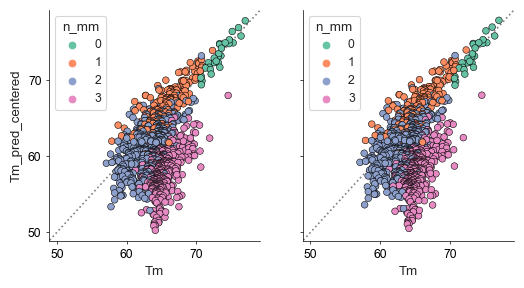

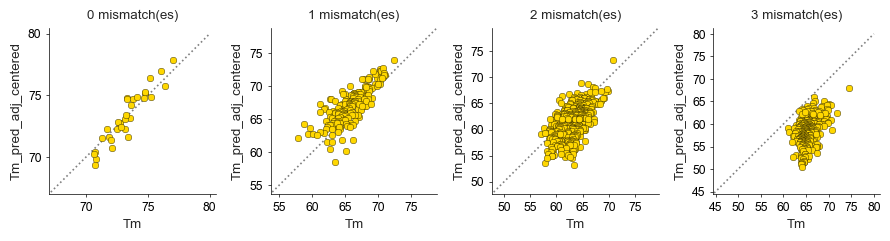

In [24]:
ov_val_result_df = report_dict['soft-yoghurt_ov_table'].reset_index()#pd.read_csv('./data/wandb_gnn/test_8_runs/ov_table_rural-haze-247.csv')
val_df = pd.read_csv('./data/models/raw/combined_dataset.csv', index_col=0)
data_split = fileio.read_json('./data/models/raw/combined_data_split.json')

# Get ov_df
split = 'test'
dataset_name = 'ov'
dataset_mask =val_df.eval('dataset == "%s"' % dataset_name)
split_ind = np.searchsorted(val_df.index, 
        data_split[split+'_ind'])
ind = list(set(split_ind) & set(np.where(dataset_mask)[0]))
ov_df = val_df.iloc[ind,:]

ov_df['n_mm'] = ov_df.TargetStruct.apply(lambda x: int(x.count('.')/2))
ov_val_result_df['n_mm'] = ov_df['n_mm'].values
ov_val_result_df['sodium'] = ov_df['sodium'].values
ov_val_result_df['GC'] = ov_df.RefSeq.apply(util.get_GC_content).values

ov_val_result_df['Tm_pred_adj'] = ov_val_result_df.apply(
    lambda row: util.get_Na_adjusted_Tm(Tm=row.Tm_pred, dH=None, GC=row.GC, Na=row.sodium, from_Na=.088), 
    axis=1)

cols = ['Tm', 'Tm_pred', 'Tm_pred_adj']
col_means = ov_val_result_df.query('n_mm < 1')[cols].mean(axis=0)
ov_val_result_df['Tm_pred_centered'] = ov_val_result_df['Tm_pred'] - col_means['Tm_pred'] + col_means['Tm']
ov_val_result_df['Tm_pred_adj_centered'] = ov_val_result_df['Tm_pred_adj'] - col_means['Tm_pred_adj'] + col_means['Tm']

### PLOTTING ###
fig, ax = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True)
sns.scatterplot(data=ov_val_result_df, x='Tm', y='Tm_pred_centered', hue='n_mm', 
                palette='Set2', marker='o', edgecolor='k', ax=ax[0])
sns.scatterplot(data=ov_val_result_df, x='Tm', y='Tm_pred_adj_centered', hue='n_mm', 
                palette='Set2', marker='o', edgecolor='k', ax=ax[1])
util.beutify_all_ax(ax, force_same_xy=True, x_locator=10, y_locator=10)
lim=[40,80]
for a in ax:
    a.plot(lim, lim, 'gray', linestyle=':', zorder=0)

fig,ax = plt.subplots(1,4,figsize=(9,2.5))#, sharex=True, sharey=True)
lim=[35,80]
for i in range(4):
    sns.scatterplot(data=ov_val_result_df.query('n_mm == %d'%i), x='Tm', y='Tm_pred_adj_centered',  
                color='gold', marker='o', edgecolor='k', linewidth=.25, ax=ax[i])
    ax[i].set_title('%d mismatch(es)'%i)
    # ax[i].set_xlim(lim)
    # ax[i].set_ylim(lim)
    # util.beutify(ax[i], x_locator=10, y_locator=10)
    util.beutify(ax[i], force_same_xy=True, add_margin=0.2, x_locator=5, y_locator=5)

for a in ax:
    a.plot(lim, lim, 'gray', linestyle=':', zorder=0)
plt.tight_layout()
util.save_fig('./fig/Fig5/ov_val_by_n_mm.pdf', fig=fig)

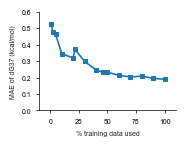

In [76]:
df = report_dict['use_train_set_ratio_sweep']
df = df.query('use_train_set_ratio <= 1')
df['% training data used'] = df.use_train_set_ratio * 100
fig, ax = plt.subplots()
# kwargs = dict(x='epoch', y='value', estimator='median', errorbar=('pi', 95), ax=ax)
sns.lineplot(data=df, x='% training data used', y='dG_37_mae', 
             marker='s', markeredgecolor=None, markersize=3)
# sns.lineplot(clean_df(report_dict['test_rmse']), label='test RMSE', **kwargs)
ax.set_xlim([-10,110])
ax.set_ylim([0,.6])
# ax.set_xlabel('epoch')
ax.set_ylabel('MAE of dG37 (kcal/mol)')

util.beutify(ax, shrink=True, x_locator=25, y_locator=.1)

util.save_fig('./fig/Fig5/test_200epoch_use_train_set_ratio_vs_dG_37_mae.pdf')

## Scatter plot of array test results

In [12]:
mydata = tnn.MyData()
mydata.load_everything()

test_result = np.load('./data/models/out/test_result_ancient-sound-259.npz')

assert test_result['y'].shape == test_result['pred'].shape

test_result_df = pd.DataFrame(data=np.concatenate((test_result['y'], test_result['pred']), axis=1),
                              columns=['dH', 'Tm', 'dH_pred', 'Tm_pred'],
                              index=mydata.data_split_dict['test_ind'])

test_result_df['dG_37'] = util.get_dG(dH=test_result_df.dH, Tm=test_result_df.Tm, celsius=37)
test_result_df['dG_37_pred'] = util.get_dG(dH=test_result_df.dH_pred, Tm=test_result_df.Tm_pred, celsius=37)
test_result_df = test_result_df.join(mydata.annotation[['Series']])

In [25]:
metric_dict = {p: modeling.get_metric_dict(test_result_df, p) for p in ['dG_37', 'dH', 'Tm']}
metric_dict['Tm_ov'] = modeling.get_metric_dict(ov_val_result_df, 'Tm')
metric_dict['Tm_lit_uv'] = modeling.get_metric_dict(lit_uv_val_result_df, 'Tm')

In [35]:
# R2 score split by number of mismatch
for n_mm in range(4):
    df_q = ov_val_result_df.query('n_mm == %d'%n_mm)
    print('%d\t%.2f' % (n_mm, modeling.get_metric_dict(df_q, 'Tm')['r2']))

0	0.78
1	0.56
2	-0.12
3	-1.21


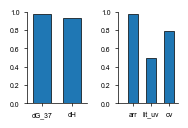

In [122]:
run_name = 'ancient-sound-259'
fig, ax = plt.subplots(1, 2, figsize=(5*cm,3.5*cm))
kwargs = dict(edgecolor='k', linewidth=.5, width=.6)

metric = 'corr'
ax[0].bar(['dG_37', 'dH'], [metric_dict[p][metric] for p in ['dG_37', 'dH']], **kwargs)
ax[0].set_xlim([-.5, 1.5])

# values = report_dict['summary'].loc[run_name, ['Tm_corr', 'Tm_corr_lit_uv', 'Tm_corr_ov']]
ax[1].bar(['arr', 'lit_uv', 'ov'], 
          [metric_dict[p][metric] for p in ['Tm', 'Tm_ov', 'Tm_lit_uv']], 
          **kwargs)
ax[1].set_xlim([-.8, 2.5])

for a in ax:
    a.set_ylim(bottom=0, top=1)
    util.beutify(a, shrink=True, do_not_resize=True)
    
plt.tight_layout()
util.save_fig(f'./fig/Fig5/test_{run_name}_{metric}.pdf')

In [68]:
def plot_test_result_scatter(test_result_df, run_name, p='Tm', 
                            kalvin_Tm=False, center_Tm=True):

    if p == 'Tm':
        tick_spacing = 20
    elif p == 'dG_37':
        tick_spacing = 2
        lim = [-6, 2]
    elif p == 'dH':
        tick_spacing = 15
    df_q = test_result_df.copy()
    # df_q = df_q.query(f'{p}_pred < 300 and {p}_pred > -300')

    # arr
    fig, ax = plt.subplots(1, 1, figsize=(3*cm,3.5*cm), sharey=False, sharex=False)
 
    matplotlib.rc('axes',edgecolor='k', linewidth=.5)
    sns.scatterplot(
        data=df_q,
        x=p,
        y=f'{p}_pred',
        color='darkmagenta',
        marker='o', 
        edgecolor='k',
        linewidth=0.1,
        s=10,
        ax=ax
    )
    ax.plot(lim, lim, 'gray', linestyle=':', zorder=0)
    # ax.axis('square')


    util.beutify(ax, x_locator=tick_spacing, y_locator=tick_spacing, 
                 force_same_xy=True, add_margin=.05, shrink=True, do_not_resize=True)
    metric = modeling.get_metric_dict(df_q, p)
    ax.set_title('MAE = %.2f kcal/mol\nR = %.2f  R2 = %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
    ax.set_ylabel(None)

    fig.tight_layout()
    util.save_fig('./fig/Fig5/scatterplot/%s/array_test_%s_all.pdf' % (run_name, p))
    
    # ===== arr by Series =====
    fig, ax = plt.subplots(1, 5, figsize=(11*cm,2*cm), sharey=False, sharex=False)
    for i,s in enumerate(['WatsonCrick', 'MisMatches', 'Bulges', 'TETRAloop', 'TRIloop']):
        matplotlib.rc('axes',edgecolor='k', linewidth=.5)
        sns.scatterplot(
            data=df_q.query(f'Series == "{s}"'),
            x=p,
            y=f'{p}_pred',
            color='darkmagenta',
            marker='o', 
            edgecolor='k',
            linewidth=0.1,
            s=10,
            ax=ax[i]
        )
        # ax[i].axis('square')
            
        util.beutify(ax[i], x_locator=tick_spacing, y_locator=tick_spacing, 
                     force_same_xy=True, add_margin=.2, shrink=True, do_not_resize=True)
        ax[i].set_title(s)
        metric = modeling.get_metric_dict(df_q.query(f'Series == "{s}"'), p)
        # ax[i].set_title('%s\nMAE = %.2f\ncorr = %.2f' % (s, metric['adjusted_mae'], metric['corr']))
        ax[i].set_title('MAE = %.2f\nR = %.2f\nR2= %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
        ax[i].set_ylabel(None)
        ax[i].plot(lim, lim, 'gray', linestyle=':', zorder=0)

    fig.tight_layout()
    util.save_fig('./fig/Fig5/scatterplot/%s/array_test_%s_by_series.pdf' % (run_name, p))

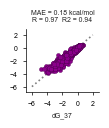

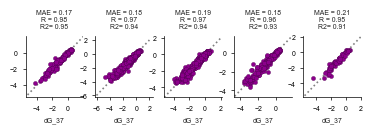

In [69]:
plot_test_result_scatter(test_result_df, 'ancient-sound-259',
                           p='dG_37',)

## GAT comparison

In [123]:
df = pd.read_csv('./data/wandb_gnn/GAT_GTransformer.csv')

In [131]:
[df[p+'_'+metric] for p in ['dG_37', 'dH']]

[0    0.293136
 1    0.183115
 Name: dG_37_mae, dtype: float64,
 0    3.722662
 1    3.130506
 Name: dH_mae, dtype: float64]

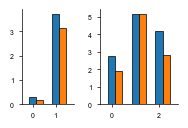

In [154]:
fig, ax = plt.subplots(1, 2, width_ratios=[2, 3], figsize=(5*cm,3.5*cm))
kwargs = dict(edgecolor='k', linewidth=.5, width=.3)

metric = 'mae'
for i in range(2):
    ax[0].bar(np.arange(2) + .3*i, [df[p+'_'+metric][i] for p in ['dG_37', 'dH']], **kwargs)
    ax[1].bar(np.arange(3) + .3*i, 
          [df['Tm_'+metric+'_adj'+dset][i] for dset in ['_arr', '_lit_uv', '_ov']], 
          **kwargs)
ax[0].set_xlim([-.5, 1.8])
ax[1].set_xlim([-.5, 2.8])

for a in ax:
    a.set_ylim(bottom=0)
    util.beutify(a, shrink=True, do_not_resize=True)
    
plt.tight_layout()
util.save_fig(f'./fig/Fig5/test_GAT_vs_GTransformer_{metric}.pdf')

## Intermediate activation

In [163]:
import umap

import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'browser'

In [354]:
test_result = np.load('./data/models/out/test_result_ancient-sound-259_aggr_out.npz')
extra_test_result = np.load('./data/models/out/test_result_ancient-sound-259_aggr_out_extra.npz')
assert test_result['y'].shape == test_result['pred'].shape

test_result_df = pd.DataFrame(data=np.concatenate((test_result['y'], test_result['pred']), axis=1),
                              columns=['dH', 'Tm', 'dH_pred', 'Tm_pred'],
                              index=mydata.data_split_dict['test_ind'])

test_result_df['dG_37'] = util.get_dG(dH=test_result_df.dH, Tm=test_result_df.Tm, celsius=37)
test_result_df['dG_37_pred'] = util.get_dG(dH=test_result_df.dH_pred, Tm=test_result_df.Tm_pred, celsius=37)
test_result_df = test_result_df.join(mydata.annotation[['Series']])

In [357]:
extra_test_result['lit_uv'].shape

(174, 250)

In [ ]:
extra_test_result_df = pd.DataFrame(data=np.concatenate((extra_test_result['y'], test_result['pred']), axis=1),
                              columns=['dH', 'Tm', 'dH_pred', 'Tm_pred'],
                              index=mydata.data_split_dict['test_ind'])

test_result_df['dG_37'] = util.get_dG(dH=test_result_df.dH, Tm=test_result_df.Tm, celsius=37)
test_result_df['dG_37_pred'] = util.get_dG(dH=test_result_df.dH_pred, Tm=test_result_df.Tm_pred, celsius=37)
test_result_df = test_result_df.join(mydata.annotation[['Series']])

In [361]:
mydata.lit_uv_data_split['test_ind']

['DP255',
 'DP114',
 'DP314',
 'DP268',
 'DP167',
 'DP124',
 'DP203',
 'DP224',
 'DP284',
 'DP153',
 'DP75',
 'DP155',
 'DP326',
 'DP110',
 'DP172',
 'DP39',
 'DP296',
 'DP77',
 'DP56',
 'DP176',
 'DP262',
 'DP45',
 'DP163',
 'DP271',
 'DP82',
 'DP25',
 'DP140',
 'DP9',
 'DP139',
 'DP193',
 'DP109',
 'DP116',
 'DP22',
 'DP225',
 'DP210',
 'DP55',
 'DP42',
 'DP30',
 'DP231',
 'DP336',
 'DP118',
 'DP84',
 'DP108',
 'DP5',
 'DP277',
 'DP119',
 'DP57',
 'DP199',
 'DP73',
 'DP322',
 'DP337',
 'DP3',
 'DP258',
 'DP145',
 'DP237',
 'DP281',
 'DP46',
 'DP287',
 'DP72',
 'DP113',
 'DP158',
 'DP33',
 'DP63',
 'DP244',
 'DP76',
 'DP93',
 'DP180',
 'DP183',
 'DP197',
 'DP325',
 'DP177',
 'DP78',
 'DP90',
 'DP16',
 'DP66',
 'DP126',
 'DP7',
 'DP220',
 'DP345',
 'DP309',
 'DP305',
 'DP94',
 'DP152',
 'DP165',
 'DP261',
 'DP60',
 'DP338',
 'DP245',
 'DP101',
 'DP208',
 'DP132',
 'DP17',
 'DP24',
 'DP311',
 'DP198',
 'DP333',
 'DP324',
 'DP344',
 'DP195',
 'DP185',
 'DP331',
 'DP175',
 'DP148',
 'DP19

In [386]:
test_result_df = test_result_df.join(mydata.annotation['RefSeq'])
test_result_df['seq_length'] = test_result_df.RefSeq.apply(len)
test_result_df['GC'] = test_result_df.RefSeq.apply(util.get_GC_content)

In [419]:
test_result['aggr_out'].shape, extra_test_result['lit_uv'].shape, extra_test_result['ov'].shape

((1438, 250), (174, 250), (1388, 250))

In [366]:
aggr_out = np.concatenate(
    (test_result['aggr_out'], extra_test_result['lit_uv'], extra_test_result['ov']),
    axis=0
)

dataset_vec = np.concatenate(
 (np.zeros(len(test_result['aggr_out'])), 
  np.ones(len(extra_test_result['lit_uv'])), 
  2*np.ones(len(extra_test_result['ov'])))
).astype(int)

In [444]:
inds_all = mydata.data_split_dict['test_ind'] + \
    mydata.lit_uv_data_split['test_ind'] + \
    mydata.ov_data_split['test_ind']

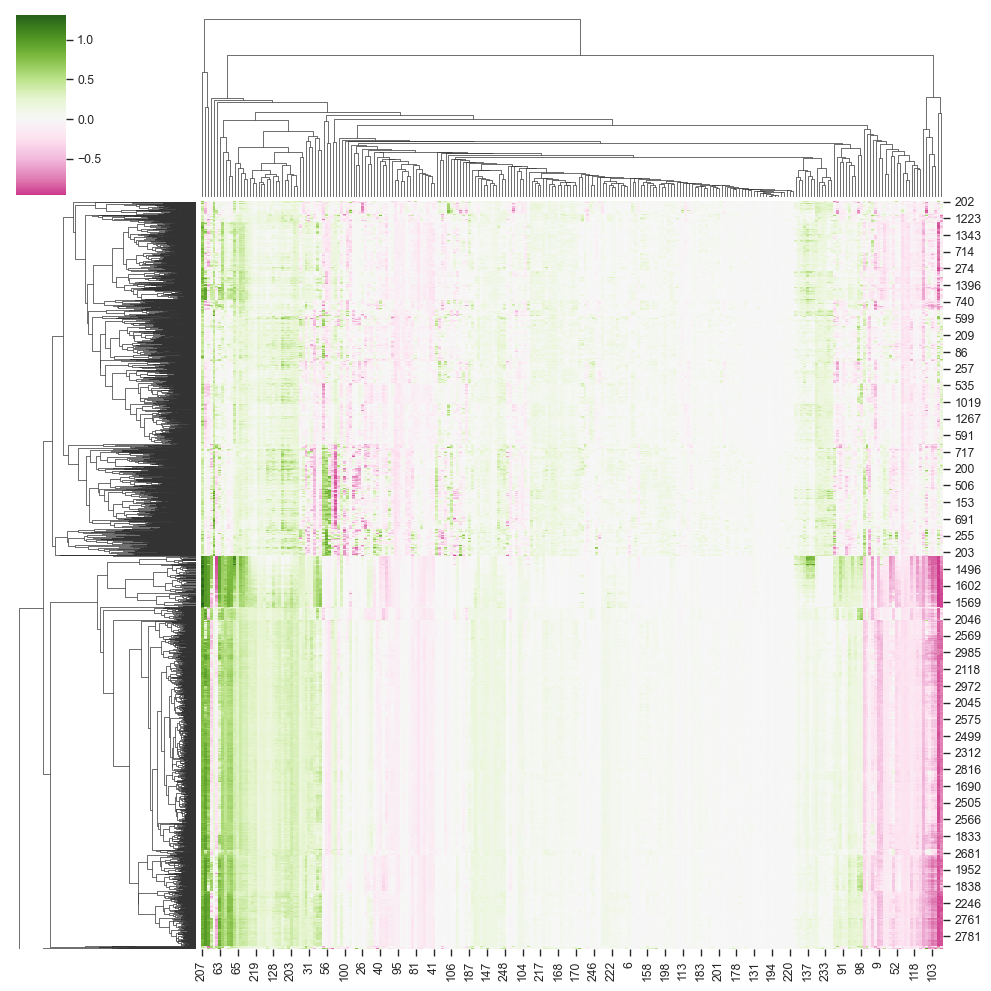

In [379]:
# n_variant x n_channel heatmap
sns.clustermap(
    aggr_out,
    center=0,
    cmap='PiYG'
)
util.save_fig('./fig/Fig5/embedding/activation_clustermap.pdf')

In [368]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(aggr_out)

PCA()

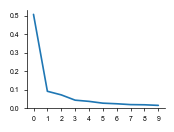

In [369]:
plt.plot(pca.explained_variance_ratio_[:10])
plt.ylim(bottom=0)
util.beutify(plt.gca(), x_locator=1, shrink=True)

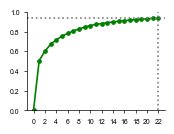

In [381]:
explained_ratio = np.cumsum(pca.explained_variance_ratio_)
explained_ratio = np.concatenate([[0], explained_ratio])
plt.plot(explained_ratio[:30], marker='.', c='g')
plt.axhline(.94, c='gray', linestyle=':')
plt.axvline(22, c='gray', linestyle=':')
plt.ylim(bottom=0, top=1)
util.beutify(plt.gca(), x_locator=2, shrink=True)

Keep 22 PCs...

In [376]:
pca = PCA(n_components=22)
aggr_pca = pca.fit_transform(aggr_out)

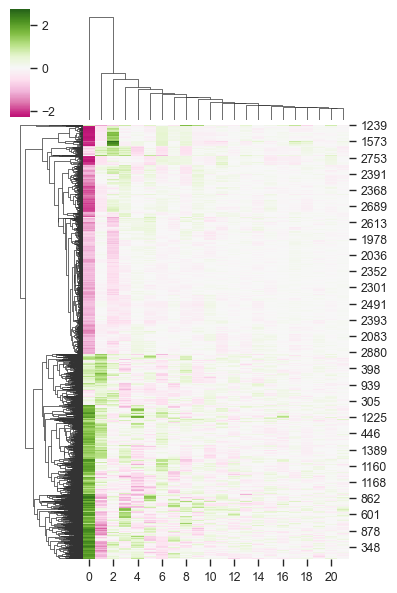

In [378]:
# n_variant x n_channel heatmap
sns.clustermap(
    aggr_pca,
    center=0,
    cmap='PiYG',
    figsize=(4,6)
)
util.save_fig('./fig/Fig5/embedding/PC_clustermap.pdf')

In [383]:
pc_cols = ['PC%02d' % (i+1) for i in range(22)]
test_result_df[['PC%02d' % (i+1) for i in range(22)]] = aggr_pca[:1438,:]

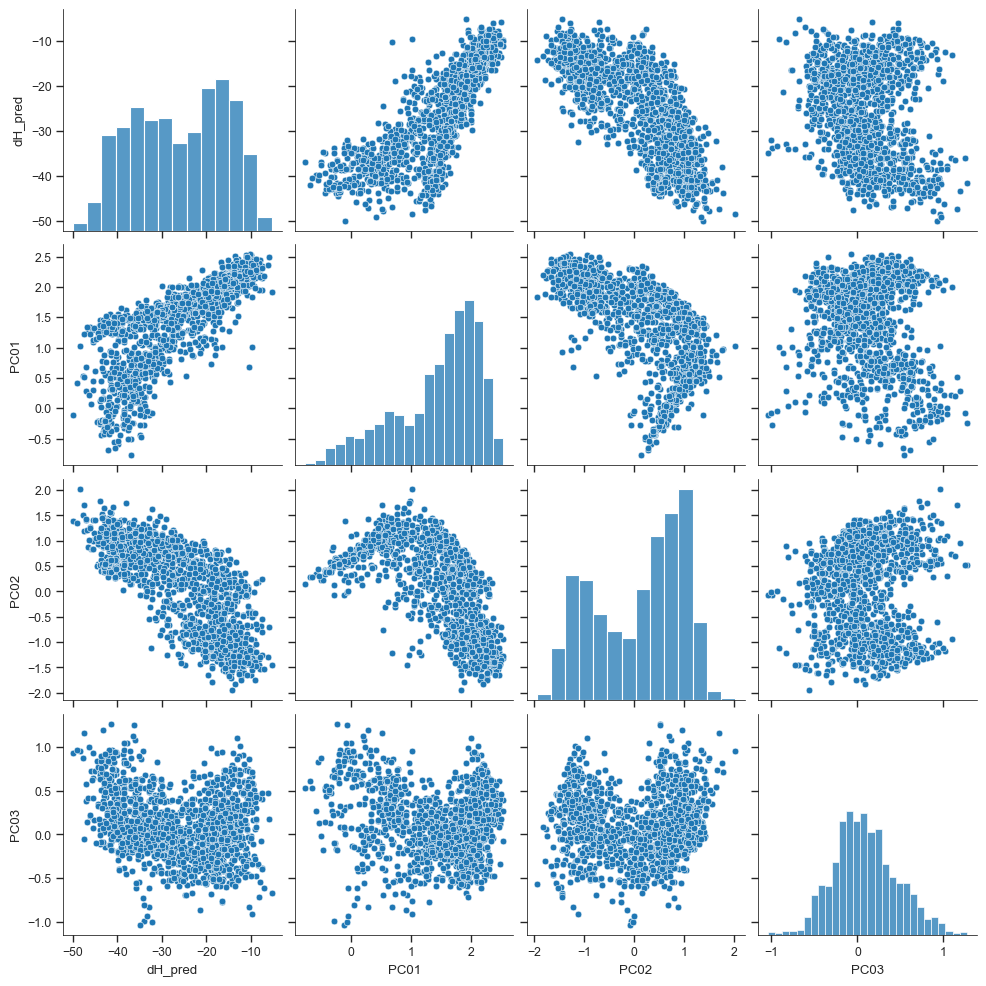

In [384]:
sns.pairplot(
    data=test_result_df,
    vars=['dH_pred', 'PC01', 'PC02', 'PC03'],
    kind='scatter',
)

In [387]:
variables = ['dH_pred', 'Tm_pred', 'dG_37_pred', 'seq_length', 'GC']
pc_corr_df = pd.DataFrame(columns=variables, index=pc_cols, dtype=float)

for pc in pc_cols:
    for v in variables:
        pc_corr_df.loc[pc, v] = util.pearson_r(test_result_df[pc], test_result_df[v])

In [531]:
pc_corr_df

,dH_pred,Tm_pred,dG_37_pred,seq_length,GC
PC01,0.799352,-0.635573,0.790932,0.023316,0.046657
PC02,-0.777520,0.269725,-0.475312,-0.048794,-0.051487
PC03,-0.195293,-0.299841,0.041651,-0.080763,-0.005482
PC04,-0.087404,0.045740,-0.046838,-0.000860,-0.004507
PC05,0.256658,-0.771895,0.590000,0.000956,-0.043807
PC06,0.194593,-0.278639,0.254313,-0.011759,-0.009873
PC07,0.224716,-0.070375,0.223919,0.044140,0.009838
PC08,0.180704,-0.048252,0.091819,0.023806,-0.010201
PC09,-0.155959,0.226573,-0.071641,0.022158,0.013421
PC10,0.114852,-0.008764,0.094484,0.037658,-0.005199


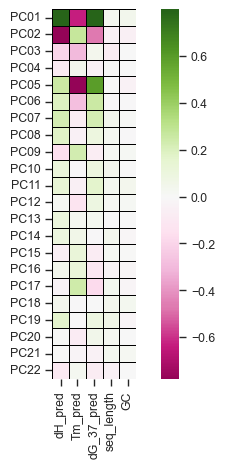

In [525]:
sns.heatmap(
    pc_corr_df,
    center=0,
    cmap='PiYG',
    edgecolor='k',
    linewidth=.5,
    linecolor='k',
    square=True
)
# util.beutify(plt.gca(), y_locator=2)
util.save_fig('./fig/Fig5/embedding/PC_variable_correlation_heatmap.pdf')

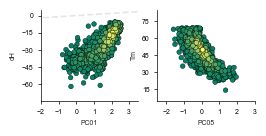

In [527]:
fig, ax = plt.subplots(1, 2, figsize=(7*cm, 3*cm))
plotting.plot_colored_scatter_comparison(
    data=test_result_df, 
    x='PC01',
    y='dH',
    edgecolor='k',
    show_cbar=False,
    palette='summer',
    ax=ax[0]
)
plotting.plot_colored_scatter_comparison(
    data=test_result_df, 
    x='PC05',
    y='Tm',
    edgecolor='k',
    show_cbar=False,
    palette='summer',
    ax=ax[1]
)

ax[0].set_xlim([-2,3.5])
ax[1].set_xlim([-2.5,3])
ax[0].set_ylim(top=5)
ax[1].set_ylim([5,85])
util.beutify_all_ax(ax, shrink=True, do_not_resize=True, 
             add_margin=.1, x_locator=1, y_locator=15)
util.save_fig('./fig/Fig5/embedding/PC_dH_Tm_examples.pdf')

In [485]:
mydata.lit_uv_df['self_comp'] = mydata.lit_uv_df.apply(lambda row: row.seq == row.rev, axis=1)

In [533]:
mydata.lit_uv_df

,Unnamed: 0,Length (bp),sodium,DNA_conc,seq,Tm,Predicted Tm (°C),RefSeq,rev,TargetStruct,self_comp
DP0,0,16,0.12,0.000005,AAAAAAAGCTTTTTTT,44.0,42.16,"[AAAAAAAGCTTTTTTT, AAAAAAAGCTTTTTTT]",AAAAAAAGCTTTTTTT,((((((((((((((((+)))))))))))))))),True
DP1,1,16,0.12,0.000007,AACGTGAATTCTGGCA,58.3,57.21,"[AACGTGAATTCTGGCA, TGCCAGAATTCACGTT]",TGCCAGAATTCACGTT,((((((((((((((((+)))))))))))))))),False
DP2,2,16,1.00,0.000018,CAACTTGATATTAATA,52.0,55.66,"[CAACTTGATATTAATA, TATTAATATCAAGTTG]",TATTAATATCAAGTTG,((((((((((((((((+)))))))))))))))),False
DP3,3,16,1.00,0.000100,CATATTGGCCAATATG,65.3,64.53,"[CATATTGGCCAATATG, CATATTGGCCAATATG]",CATATTGGCCAATATG,((((((((((((((((+)))))))))))))))),True
DP4,4,17,0.10,0.000004,CTCGTACCTTCCGGTCC,60.6,63.05,"[CTCGTACCTTCCGGTCC, GGACCGGAAGGTACGAG]",GGACCGGAAGGTACGAG,(((((((((((((((((+))))))))))))))))),False
...,...,...,...,...,...,...,...,...,...,...,...
DP343,343,30,0.12,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,79.8,81.19,"[GCCCCTCCACTGGCCGACGGCAGCAGGCTC, GAGCCTGCTGCCG...",GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...,False
DP344,344,30,0.22,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,83.6,84.19,"[GCCCCTCCACTGGCCGACGGCAGCAGGCTC, GAGCCTGCTGCCG...",GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...,False
DP345,345,30,0.62,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,87.1,89.33,"[GCCCCTCCACTGGCCGACGGCAGCAGGCTC, GAGCCTGCTGCCG...",GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...,False
DP346,346,30,1.02,0.000002,GCCCCTCCACTGGCCGACGGCAGCAGGCTC,87.7,91.80,"[GCCCCTCCACTGGCCGACGGCAGCAGGCTC, GAGCCTGCTGCCG...",GAGCCTGCTGCCGTCGGCCAGTGGAGGGGC,((((((((((((((((((((((((((((((+)))))))))))))))...,False


In [534]:
umap_df = pd.DataFrame(
    data=embedding,
    index=inds_all,
    columns=['UMAP1', 'UMAP2']
)

mydata.ov_df['n_mm'] = mydata.ov_df.TargetStruct.apply(lambda x: x.count('.') / 2).astype(int)
umap_df = umap_df.join(mydata.ov_df[['a', 'n_mm', 'center', 'Tm']]).join(mydata.lit_uv_df[['RefSeq', 'Length (bp)', 'self_comp', 'Tm']], rsuffix='_lit').join(mydata.annotation[['RefSeq', 'TargetStruct']], rsuffix='_arr')
umap_df = umap_df.join(mydata.arr['Tm'], rsuffix='_arr')
umap_df.Tm = umap_df.Tm.fillna(umap_df.Tm_arr).fillna(umap_df.Tm_lit)
umap_df.RefSeq = umap_df.RefSeq.fillna(umap_df.a).fillna(umap_df.RefSeq_arr)
umap_df['dataset'] = dataset_vec

umap_df = umap_df.reset_index(names=['SEQID'])

In [535]:
umap_df

,SEQID,UMAP1,UMAP2,a,n_mm,center,Tm,RefSeq,Length (bp),self_comp,Tm_lit,RefSeq_arr,TargetStruct,Tm_arr,dataset
0,BNNN8825,14.620366,-4.497250,NaN,NaN,NaN,28.015785,GCTCACGAAAGTGTCAGC,NaN,NaN,NaN,GCTCACGAAAGTGTCAGC,((((((....)))..))),28.015785,0
1,BNNN6903,6.197286,0.708725,NaN,NaN,NaN,40.928087,GGGCACGAAAGTGTACCC,NaN,NaN,NaN,GGGCACGAAAGTGTACCC,((((((....)))..))),40.928087,0
2,MMGTP2966,17.992962,3.440151,NaN,NaN,NaN,26.389602,GGTTGTGGAAACGCAATC,NaN,NaN,NaN,GGTTGTGGAAACGCAATC,(.(((.(....).))).),26.389602,0
3,MMGTP1764,16.747322,2.413789,NaN,NaN,NaN,34.161114,GGGTGAGGAAACTTGCCC,NaN,NaN,NaN,GGGTGAGGAAACTTGCCC,(((..((....))..))),34.161114,0
4,BNNN3980,12.239784,-1.737418,NaN,NaN,NaN,43.620767,GTGTACCGAAAGGTCAC,NaN,NaN,NaN,GTGTACCGAAAGGTCAC,(((.(((....)))))),43.620767,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,OV187,-2.401346,17.023743,CGACGTGCAATATGTGCTG,0.0,AAT/TTA,61.200000,CGACGTGCAATATGTGCTG,NaN,NaN,NaN,NaN,NaN,NaN,2
2996,OV619,3.357343,6.799092,CGACGTGCGAGATGTGCTG,2.0,GAG/CCG,55.400000,CGACGTGCGAGATGTGCTG,NaN,NaN,NaN,NaN,NaN,NaN,2
2997,OV1391,2.165997,10.992118,CGACGTGCTGTATGTGCTG,2.0,TGT/TCC,51.500000,CGACGTGCTGTATGTGCTG,NaN,NaN,NaN,NaN,NaN,NaN,2
2998,OV1175,-1.743005,-10.402969,CGACGTGCAAGATGTGCTG,2.0,AAG/GTT,52.500000,CGACGTGCAAGATGTGCTG,NaN,NaN,NaN,NaN,NaN,NaN,2


In [474]:
%%time
np.random.seed(42)
embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.5,
                      metric='euclidean').fit_transform(aggr_out)

CPU times: user 16.9 s, sys: 2.77 s, total: 19.7 s
Wall time: 6.73 s


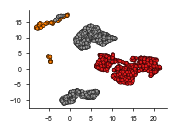

In [532]:
plt.scatter(embedding[:,0], embedding[:,1], c=dataset_vec, 
            s=5, cmap='Set1', edgecolor='k', linewidths=.25)
util.beutify(plt.gca(), shrink=True, x_locator=5)
util.save_fig('./fig/Fig5/embedding/UMAP_activation_dataset.pdf')

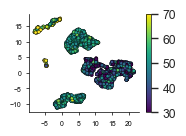

In [559]:
plt.scatter(embedding[:,0], embedding[:,1], c=umap_df.Tm, 
            s=5, cmap='viridis', edgecolor='k', linewidths=.25,
            vmin=30, vmax=70)
util.beutify(plt.gca(), shrink=True, x_locator=5)
plt.colorbar()
util.save_fig('./fig/Fig5/embedding/UMAP_activation_dataset_Tm.pdf')

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

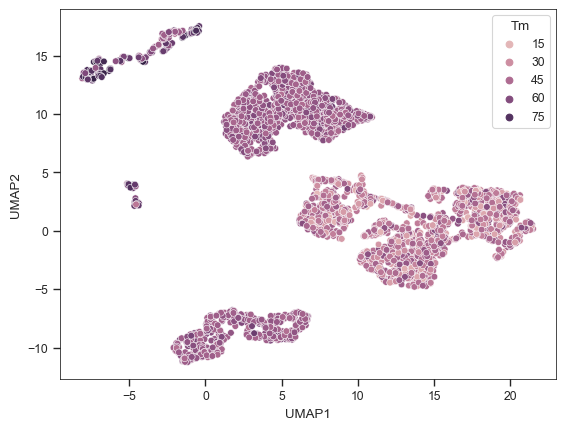

In [553]:
sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='Tm',
    vmin=20,
    vmax=50
)

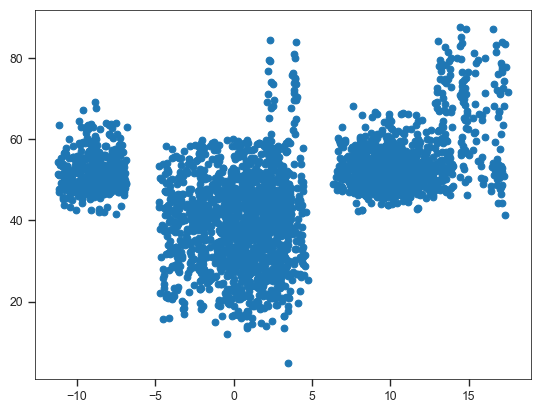

In [547]:
plt.scatter(embedding[:,1], umap_df.Tm)

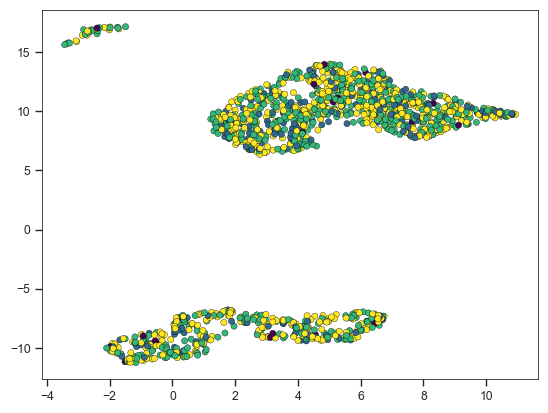

In [479]:
plt.scatter(embedding[:,0], embedding[:,1], c=umap_df.n_mm, 
            s=20, cmap='viridis', edgecolor='k', linewidths=.25)
# util.beutify(plt.gca(), shrink=True, x_locator=5)
# util.save_fig('./fig/Fig5/embedding/UMAP_activation_dataset.pdf')

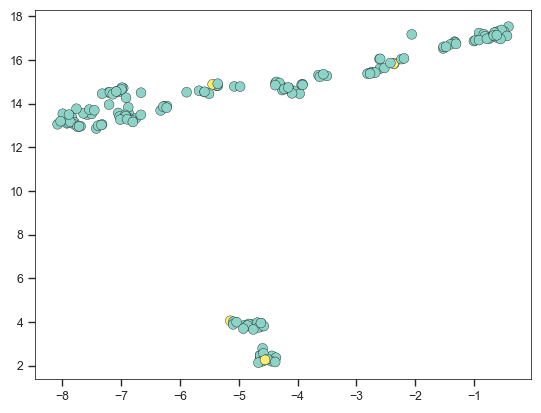

In [491]:
plt.scatter(embedding[:,0], embedding[:,1], c=umap_df['self_comp'], 
            s=50, cmap='Set3', edgecolor='k', linewidths=.25)
# util.beutify(plt.gca(), shrink=True, x_locator=5)
# util.save_fig('./fig/Fig5/embedding/UMAP_activation_dataset.pdf')

In [501]:
umap_df

,SEQID,UMAP1,UMAP2,a,n_mm,Length (bp),self_comp,RefSeq,TargetStruct
0,BNNN8825,14.620366,-4.497250,NaN,NaN,NaN,NaN,GCTCACGAAAGTGTCAGC,((((((....)))..)))
1,BNNN6903,6.197286,0.708725,NaN,NaN,NaN,NaN,GGGCACGAAAGTGTACCC,((((((....)))..)))
2,MMGTP2966,17.992962,3.440151,NaN,NaN,NaN,NaN,GGTTGTGGAAACGCAATC,(.(((.(....).))).)
3,MMGTP1764,16.747322,2.413789,NaN,NaN,NaN,NaN,GGGTGAGGAAACTTGCCC,(((..((....))..)))
4,BNNN3980,12.239784,-1.737418,NaN,NaN,NaN,NaN,GTGTACCGAAAGGTCAC,(((.(((....))))))
...,...,...,...,...,...,...,...,...,...
2995,OV187,-2.401346,17.023743,CGACGTGCAATATGTGCTG,0.0,NaN,NaN,CGACGTGCAATATGTGCTG,NaN
2996,OV619,3.357343,6.799092,CGACGTGCGAGATGTGCTG,2.0,NaN,NaN,CGACGTGCGAGATGTGCTG,NaN
2997,OV1391,2.165997,10.992118,CGACGTGCTGTATGTGCTG,2.0,NaN,NaN,CGACGTGCTGTATGTGCTG,NaN
2998,OV1175,-1.743005,-10.402969,CGACGTGCAAGATGTGCTG,2.0,NaN,NaN,CGACGTGCAAGATGTGCTG,NaN


In [511]:
hover_data=['SEQID', 'RefSeq','TargetStruct', 'center', 'n_mm']

In [519]:
fig = px.scatter(umap_df, x='UMAP1', y='UMAP2', color='dataset', 
                 hover_data=hover_data,
                 width=1200, height=1000)
# fig.write_html("./fig/residual_UMAP_series.html")
fig.show()

In [260]:
test_result_df[['UMAP1', 'UMAP2']] = embedding


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

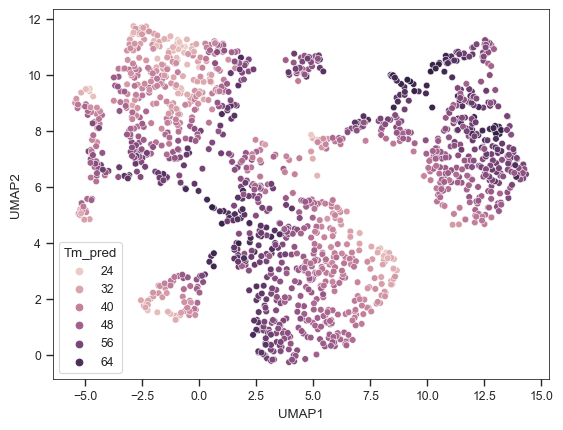

In [263]:
sns.scatterplot(
    data=test_result_df,
    x='UMAP1',
    y='UMAP2',
    hue='Tm_pred'
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

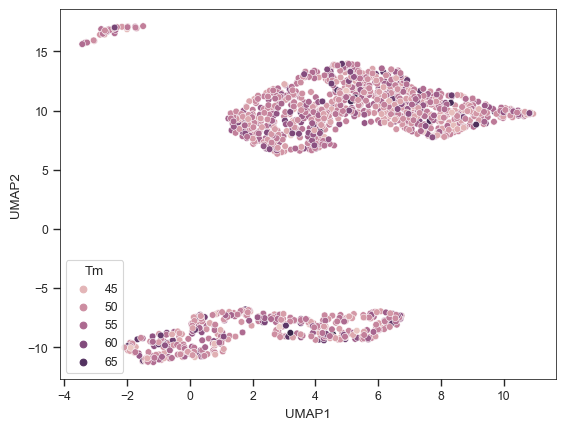

In [518]:
sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='Tm'
)

# KNN

In [39]:
# KNN results
knn_test_result_df = pd.read_csv('./data/models/knn_out/knn_test_restul_df.csv', index_col=0)

# data files used for KNN
datadir = './data/models/raw'
arr = pd.read_csv(os.path.join(datadir, 'combined_dataset.csv'), index_col=0)
with open(os.path.join(datadir, 'combined_data_split.json'), 'r') as fh:
    data_split_dict = json.load(fh)

In [40]:
knn_test_result_df['dG_37_pred'] = util.get_dG(dH=knn_test_result_df.dH_pred, Tm=knn_test_result_df.Tm_pred, celsius=37)
arr_test = arr.loc[data_split_dict['test_ind']].reset_index()

cols = ['SEQID', 'dataset', 'dG_37']
for c in cols:
    knn_test_result_df[c] = arr_test[c].values

defaultdict(None,
            {'bias': -0.2302798347347128,
             'corr': 0.8784493087431009,
             'rmse': 5.279623141516143,
             'adjusted_rmse': 5.2745987254147915,
             'mae': 4.030379141369844,
             'adjusted_mae': 4.012796311476543,
             'r2': 0.7714947046343893})

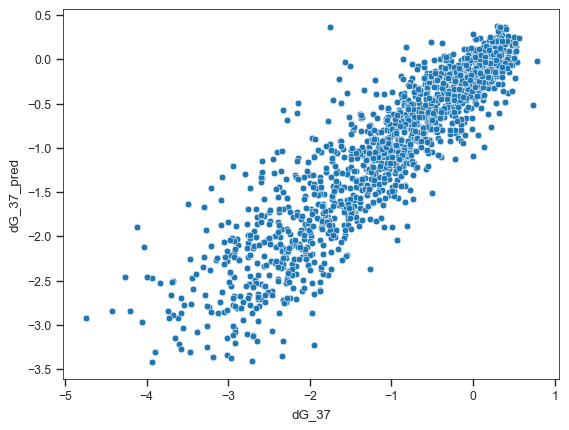

In [44]:
df_q = knn_test_result_df.query('dataset == "arr"')

sns.scatterplot(data=df_q, x='dG_37', y='dG_37_pred')
modeling.get_metric_dict(val_result_df=df_q, param='dH')

defaultdict(None,
            {'bias': 8.117133576553499,
             'corr': 0.3494915171564538,
             'rmse': 10.31581970384443,
             'adjusted_rmse': 6.366182424547129,
             'mae': 9.005536250668271,
             'adjusted_mae': 5.120050228373612,
             'r2': -1.0639369148353923})

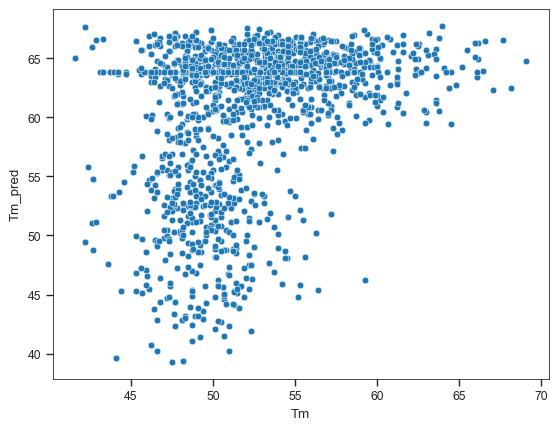

In [54]:
df_q = knn_test_result_df.query('dataset == "ov"')

sns.scatterplot(data=df_q, x='Tm', y='Tm_pred')
modeling.get_metric_dict(val_result_df=df_q, param='Tm')

In [55]:
df_q = df_q.set_index('SEQID').join(mydata.ov_df[['TargetStruct']])
df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int(x.count('.') / 2))

In [56]:
for n_mm in range(4):
    print('%d\t%.2f' % (n_mm, modeling.get_metric_dict(df_q.query('n_mm == %d' % n_mm), 'Tm')['r2']))

0	0.07
1	-0.14
2	-0.23
3	-8.33


# Fig. 5j Benchmark

In [57]:
benchmark_df = pd.read_csv('./data/Fig5_model_performance.csv')

In [58]:
benchmark_df

,model_name,dH_mae,Tm_mae,dG_37_mae,dH_R2,Tm_R2,dG_37_R2,Tm_ov_mae,Tm_ov_adjusted_mae,Tm_ov_corr,Tm_ov_r2,Tm_ov_0mm_r2,Tm_ov_1mm_r2,Tm_ov_2mm_r2,Tm_ov_3mm_r2
0,ori_NUPACK,5.59,7.94,0.87,0.12,-0.06,-0.15,5.43,2.06,0.81,0.65,0.87,0.25,0.13,0.03
1,NUPACK_compatible_NN,6.27,NaN,0.56,0.45,NaN,0.49,4.70,2.29,0.86,0.73,0.86,0.68,0.26,0.24
2,rich_NN,4.97,5.09,0.34,0.54,0.20,0.51,10.20,2.76,0.66,0.42,0.92,0.75,0.21,0.27
3,closet_lookup,5.27,3.72,0.34,0.77,0.78,0.81,9.01,5.12,0.35,-1.06,0.07,-0.14,-0.23,-8.33
4,GNN,3.13,1.80,0.19,0.86,0.94,0.94,5.56,5.30,0.78,0.49,0.78,0.56,-0.12,-1.21
5,measurement,NaN,NaN,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


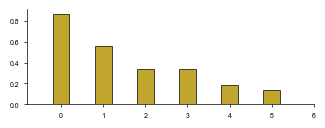

In [59]:
fig, ax = plt.subplots(figsize=(2*4.25*cm, 3.5*cm))
for n in range(6):
    ax.bar(x=n, height=benchmark_df.dG_37_mae[n], align='center',
        width=.4, color=np.array([193,167,47])/256, edgecolor='k', linewidth=.5)
ax.set_xlim([-.8,6])

util.beutify(ax, shrink=True, do_not_resize=True)
plt.tight_layout()
util.save_fig('./fig/Fig5/benchmark_dG_37_mae.pdf')

In [68]:
ov_benchmark_df = benchmark_df.set_index('model_name').iloc[:5, -4:]

In [76]:
ov_benchmark_df = ov_benchmark_df.stack().reset_index()
ov_benchmark_df.columns = ['model_name', 'metric', 'r2']

In [77]:
ov_benchmark_df

,model_name,metric,r2
0,ori_NUPACK,Tm_ov_0mm_r2,0.87
1,ori_NUPACK,Tm_ov_1mm_r2,0.25
2,ori_NUPACK,Tm_ov_2mm_r2,0.13
3,ori_NUPACK,Tm_ov_3mm_r2,0.03
4,NUPACK_compatible_NN,Tm_ov_0mm_r2,0.86
5,NUPACK_compatible_NN,Tm_ov_1mm_r2,0.68
6,NUPACK_compatible_NN,Tm_ov_2mm_r2,0.26
7,NUPACK_compatible_NN,Tm_ov_3mm_r2,0.24
8,rich_NN,Tm_ov_0mm_r2,0.92
9,rich_NN,Tm_ov_1mm_r2,0.75


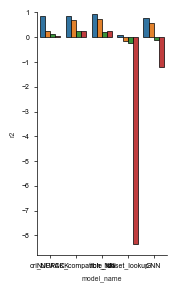

In [101]:
fig, ax = plt.subplots(figsize=(4.25*cm, 8*cm))
sns.barplot(data=ov_benchmark_df,
           x='model_name',
           y='r2',
           hue='metric',
            edgecolor='k',
           ax=ax)
plt.setp(ax.patches, linewidth=.5)
ax.set_ylim(top=1)
ax.get_legend().remove()
util.beutify(ax, y_locator=1, shrink=True, do_not_resize=True)
util.save_fig('./fig/Fig5/benchmark_ov_Tm_by_model.pdf')

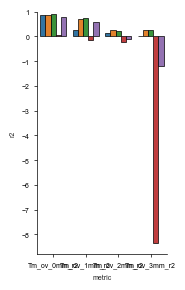

In [102]:
fig, ax = plt.subplots(figsize=(4.25*cm, 8*cm))
sns.barplot(data=ov_benchmark_df,
           hue='model_name',
           y='r2',
           x='metric',
           edgecolor='k',)
plt.setp(ax.patches, linewidth=.5)
ax.set_ylim(top=1)
ax.get_legend().remove()
util.beutify(ax, y_locator=1, shrink=True, do_not_resize=True)
util.save_fig('./fig/Fig5/benchmark_ov_Tm_by_nmm.pdf')

### NUPACK-compatible NN benchmark

In [73]:
df = pd.read_csv('./models/vivid-frog-139_val_result_df.csv', index_col=[0,1])
dna04_df = pd.read_csv('./models/dna04_val_result_df.csv', index_col=[0,1])

In [81]:
df.loc['arr']#.loc['BNNN8825']

,RefSeq,TargetStruct,dH,Tm,dG_37,dH_pred,Tm_pred,dG_37_pred
MMGTP971,GTGTGTGGAAACATACAC,((((.((....)).)))),-39.560910,48.576922,-1.423548,-37.693292,84.445272,-5.001097
MMACP1924,GGATGGGGAAACCCACCC,((.((((....)))).)),-24.153575,45.125265,-0.616618,-21.639664,145.212525,-5.597257
BNNN315,GAATCCGAAAGGAGCTTC,((((((....)))..))),-23.634372,41.630497,-0.347667,-10.051351,336.313499,-4.936317
TETNNN3073,GATCCAAAATTGGATC,((((((....)))))),-35.827860,48.066638,-1.234351,-44.058128,71.417524,-4.400797
BNNN8635,GCTTCCGAAAGGAGCAGC,((((((....)))..))),-15.184097,41.673821,-0.225421,-11.551351,390.332284,-6.151581
...,...,...,...,...,...,...,...,...
MMGTP2431,GCGGTGGGAAACCATCGC,(((.(((....))).))),-40.873508,61.823929,-3.029015,-36.739066,119.521725,-7.720880
TETNNN3912,GATCCCTACAGGGATC,((((((....)))))),-36.163026,65.585222,-3.051729,-56.583677,84.779329,-7.553251
BNNN1223,GATCGCGAAAGCGTAATC,((((((....)))..))),-8.801201,29.224773,0.226313,-15.751351,225.819150,-5.960602
MMGTP3108,GGGGTAGGAAACTGCCTC,(.((.((....)).)).),-25.114965,38.046121,-0.084427,-23.809721,91.811979,-3.575874


In [82]:
dna04_df.loc['arr']

,RefSeq,TargetStruct,dH,Tm,dG_37,dH_pred,Tm_pred,dG_37_pred
BNNN8825,GCTCACGAAAGTGTCAGC,((((((....)))..))),-17.444959,37.364195,-0.020461,-38.5,44.781669,-0.942323
BNNN6903,GGGCACGAAAGTGTACCC,((((((....)))..))),-18.396976,50.276497,-0.755187,-39.1,46.863531,-1.205149
MMGTP2966,GGTTGTGGAAACGCAATC,(.(((.(....).))).),-20.558740,35.738012,0.083994,-21.5,-7.618897,3.612783
MMGTP1764,GGGTGAGGAAACTTGCCC,(((..((....))..))),-22.890342,43.509524,-0.470553,-34.6,37.158763,-0.017702
BNNN3980,GTGTACCGAAAGGTCAC,(((.(((....)))))),-30.529200,52.969177,-1.494933,-47.7,41.250766,-0.644914
...,...,...,...,...,...,...,...,...
MMCNN88,CGTCCCGGAAACGGCACG,(((.(((....))).))),-23.721161,39.865573,-0.217161,-33.0,74.975759,-3.599849
TETNNN707,GATCAGGAAGCTGATC,((((((....)))))),-34.218804,53.863181,-1.764571,-45.2,53.754691,-2.316614
WC135,AAGCTGAAAAGCTT,(((((....))))),-21.073752,49.277133,-0.802430,-34.1,64.112159,-2.741264
TRINNN512,GATCGAAAATCGATC,((((((...)))))),-29.869540,47.648214,-0.991456,-40.2,53.501182,-2.030752


In [83]:
arr_df = df.loc['arr']

In [40]:
sns.histplot(Tm_pred_corrected, arr_df.Tm)

TypeError: histplot() takes from 0 to 1 positional arguments but 2 were given

(0.0, 80.0)

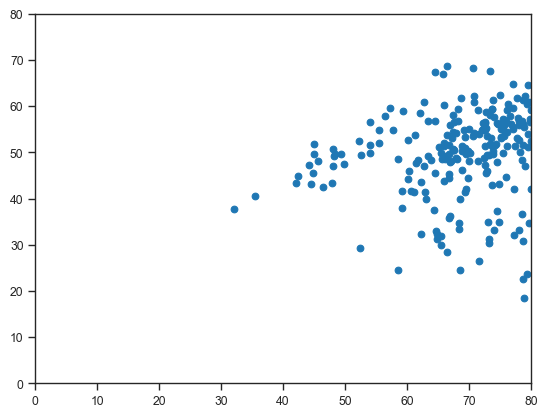

In [99]:
plt.scatter(arr_df.Tm_pred, arr_df.Tm)
plt.xlim([0,80])
plt.ylim([0,80])

In [84]:
ddG = np.mean(arr_df.dG_37 - arr_df.dG_37_pred)
ddH = np.mean(arr_df.dH - arr_df.dH_pred)

In [85]:
Tm_pred_corrected = util.get_Tm(arr_df.dH+ddH, arr_df.dG_37+ddG)

In [88]:
r2_score(arr_df.Tm, Tm_pred_corrected), r2_score(arr_df.Tm, arr_df.Tm_pred)

(-35.13906508566905, -201.46279773340135)

In [89]:
arr_df

,RefSeq,TargetStruct,dH,Tm,dG_37,dH_pred,Tm_pred,dG_37_pred
MMGTP971,GTGTGTGGAAACATACAC,((((.((....)).)))),-39.560910,48.576922,-1.423548,-37.693292,84.445272,-5.001097
MMACP1924,GGATGGGGAAACCCACCC,((.((((....)))).)),-24.153575,45.125265,-0.616618,-21.639664,145.212525,-5.597257
BNNN315,GAATCCGAAAGGAGCTTC,((((((....)))..))),-23.634372,41.630497,-0.347667,-10.051351,336.313499,-4.936317
TETNNN3073,GATCCAAAATTGGATC,((((((....)))))),-35.827860,48.066638,-1.234351,-44.058128,71.417524,-4.400797
BNNN8635,GCTTCCGAAAGGAGCAGC,((((((....)))..))),-15.184097,41.673821,-0.225421,-11.551351,390.332284,-6.151581
...,...,...,...,...,...,...,...,...
MMGTP2431,GCGGTGGGAAACCATCGC,(((.(((....))).))),-40.873508,61.823929,-3.029015,-36.739066,119.521725,-7.720880
TETNNN3912,GATCCCTACAGGGATC,((((((....)))))),-36.163026,65.585222,-3.051729,-56.583677,84.779329,-7.553251
BNNN1223,GATCGCGAAAGCGTAATC,((((((....)))..))),-8.801201,29.224773,0.226313,-15.751351,225.819150,-5.960602
MMGTP3108,GGGGTAGGAAACTGCCTC,(.((.((....)).)).),-25.114965,38.046121,-0.084427,-23.809721,91.811979,-3.575874


In [91]:
param_set_template_file = './models/dna04.json'
param_json_file = './models/vivid-frog-139.json'

p_old_dict = fileio.read_json(param_set_template_file)
p_new_dict = fileio.read_json(param_json_file)

In [92]:
p_old_dict['dG'].keys()

dict_keys(['bulge_size', 'coaxial_stack', 'dangle_3', 'dangle_5', 'hairpin_size', 'hairpin_mismatch', 'hairpin_tetraloop', 'hairpin_triloop', 'interior_1_1', 'interior_1_2', 'interior_2_2', 'interior_mismatch', 'interior_size', 'join_penalty', 'log_loop_penalty', 'multiloop_base', 'multiloop_init', 'multiloop_pair', 'asymmetry_ninio', 'stack', 'terminal_penalty', 'terminal_mismatch'])

In [93]:
dG_hairpin = lambda p: p['dG']['hairpin_tetraloop']['CGAAAG']
dG_hairpin(p_old_dict), dG_hairpin(p_new_dict)

(-1.1, -0.9743301251078842)

In [94]:
dG_hairpin = lambda p: p['dG']['hairpin_mismatch']['ACGG']
dG_hairpin(p_old_dict), dG_hairpin(p_new_dict)

(-1.0, -4.234636837314402)

In [101]:
dG_hairpin = lambda p: (p['dG']['hairpin_mismatch']['AGCG'], p['dG']['interior_mismatch']['AGCG'])
dG_hairpin(p_old_dict), dG_hairpin(p_new_dict)

((-1.0, -1.0), (-5.331840993074127, -1.3176821572380186))

In [96]:
terminal = lambda p: p['dG']['terminal_penalty']
terminal(p_old_dict), terminal(p_new_dict)

({'AA': 0.0,
  'AC': 0.0,
  'AG': 0.0,
  'AT': 0.05,
  'CA': 0.0,
  'CC': 0.0,
  'CG': 0.0,
  'CT': 0.0,
  'GA': 0.0,
  'GC': 0.0,
  'GG': 0.0,
  'GT': 0.05,
  'TA': 0.05,
  'TC': 0.0,
  'TG': 0.05,
  'TT': 0.0},
 {'AA': 0.0,
  'AC': 0.0,
  'AG': 0.0,
  'AT': 0.05,
  'CA': 0.0,
  'CC': 0.0,
  'CG': 0.0,
  'CT': 0.0,
  'GA': 0.0,
  'GC': 0.0,
  'GG': 0.0,
  'GT': 0.05,
  'TA': 0.05,
  'TC': 0.0,
  'TG': 0.05,
  'TT': 0.0})

In [67]:
p_new_dict['dG']['hairpin_mismatch']

{'AATA': -0.27268184127990347,
 'AATC': -0.3966562853391764,
 'AATG': -1.1840062044299997,
 'AATT': -0.8242156858344942,
 'ACGA': -0.11491773726326215,
 'ACGC': -0.4181274451911583,
 'ACGG': -1.3554463594478503,
 'ACGT': -1.0488450800594173,
 'AGCA': -1.2495704148462043,
 'AGCC': -1.10073307763369,
 'AGCG': -2.458234188267993,
 'AGCT': -1.4923345522824296,
 'AGTA': -0.5,
 'AGTC': -0.2,
 'AGTG': -0.5,
 'AGTT': -0.5,
 'ATAA': 0.32346297652467504,
 'ATAC': 0.1065879610941991,
 'ATAG': -0.5955437092764284,
 'ATAT': -0.9175369507458728,
 'ATGA': -0.5,
 'ATGC': -0.2,
 'ATGG': -0.5,
 'ATGT': -0.5,
 'CATA': -0.41006625456252577,
 'CATC': -0.2299606366070286,
 'CATG': -1.3170894671479476,
 'CATT': -0.4115220900097678,
 'CCGA': 0.03418818603648388,
 'CCGC': -0.14047515624933826,
 'CCGG': -1.069511427012793,
 'CCGT': -0.33987200180555277,
 'CGCA': -1.2050253837574263,
 'CGCC': -0.9280475771651067,
 'CGCG': -1.9318728537024463,
 'CGCT': -1.0756400711742642,
 'CGTA': -0.2,
 'CGTC': -0.2,
 'CGTG': -